# EA Tutorial

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import random
import math
import matplotlib as mpl

from scipy import optimize
from ortools.linear_solver import pywraplp

from sklearn.linear_model import LinearRegression

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

## Problem Description 

We are given n players, each with their own objective function that they seek to optimize, subject to shared constraints. 
Here, we have 2 players, and 2 constraints:

$$\begin{align}
    f_{1}(x) = (x-1)^2 \\f_{2}(y) = (y-0.5)^2\\ \\obj(P1) = min_{x} f_{1}(x) \\ obj(P2) =  min_{y}f_{2}(y)
\end{align}$$

Subject to
$$x,y \geq 0 \\x+y \leq 1 $$
                              

A Nash Equilibirum is defined as a point at which each player has optimized their objective function subject to the constraints, assuming that variables they do not control remain fixed. For this problem, our solution set is given by 
$$(x,y) = (t,1-t) \mid t \in [0.5,1] $$


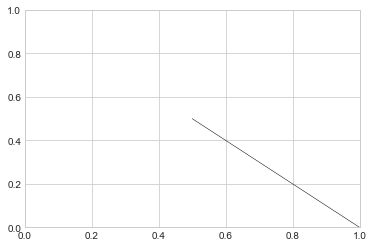

The solution set is given by (x,y) = (t, 1-t) such that 0.5 <= t <= 1


In [2]:
x = np.linspace(0.5, 1, 1000)
plt.plot(x,1-x, 'k', linewidth=0.5)
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()
print("The solution set is given by (x,y) = (t, 1-t) such that 0.5 <= t <= 1")

For this Evolutionary Algorithm, we follow the following general protocol: 
    1. Generate 2 * numSelect random points
    2. Calculate fitness of each of these points
    3. Rank and choose the top numSelect points, deleting the rest
    4. Perform linear regression on selected points
    5. Generate numSelect new random x values, and select corresponding y values according to the line with some randomness
    6. Repeat steps 2-5 until threshold convergence or max iterations

We will go into much more detail on each of these steps below.

## 1. Generating Initial Points

First, we calculate the global bounds for each of x and y individually, based on the constraints. Here, it is trivial that $$0 \leq x,y \leq 1$$
We select random values of x and y within their global bounds, and plot them below:


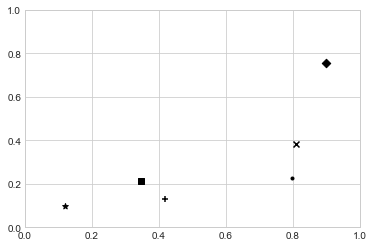

In [4]:
testNum = 6 # Number of points in each generation
numSelect = 3 # Number of SELECTED points in each gen

xPoints = np.ones(testNum)
yPoints = np.ones(testNum)

myMarkers = ['.', 'x', '*', '+', 'D', 's']

for i in range(testNum):
    xPoints[i] = random.random()
    yPoints[i] = random.random()
    plt.scatter(xPoints[i], yPoints[i], c='k', marker=myMarkers[i])
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

## 2. Calculating fitness

Let C represent our constraint set. We define the fitness of each point $p_{i}=(x_{i},y_{i})$ as the euclidean distance to its *Shadow Point*, $p_{i}*$. We define the *Shadow Point* as such:


$$p_{i}*=(x_{i}*, y_{i}*)$$
Where
$$\begin{align}
x_{i}* = min f_{1}(x) \textit{ subject to } C \mid y=y_{i}\\
y_{i}* = min f_{2}(y) \textit{ subject to } C \mid x = x_{i}
\end{align}$$

EXAMPLE: Let $$p_{j} = (0.4, 0.9)$$
$$x_{j}* = min(x-1)^2 \textit{s.t.  } x \geq 0, x+0.9\leq1 \implies x_{j}* = 0.1$$
$$y_{j}* = min(y-0.5)^2 \textit{s.t.  } y \geq 0, y+0.4\leq1 \implies y_{j}* = 0.5$$
$$\therefore p_{j}*=(0.1, 0.5)$$

    Thus
$$fitness(p_{j}) = dist(p_{j}, p_{j}*) = \sqrt{(0.4-0.1)^2 + (0.9-0.5)^2} = 0.5$$

By definition, $p_{a} \in solution set \iff p_{a}$ is a nash equilibrium $\iff p_{a} = p_{a}* \iff fitness(p_{a}) =0$

### Fitness Code

**funcx(x)** and **funcy(y)** define $f_{1}(x)$ and $f_{2}(y)$ respectively

**optimizeMe(other, funToOp)** solves for $x_{i}*$ given $y_{i}$ and $f_{1}(x)$, or $y_{i}*$ given $x_{i}$ and $f_{2}(y)$

**penalty(x, y)** takes in $p$ as $x_{i}, y_{i}$ and returns the euclidean distance to $p_{i}*$ as calculated by **optimizeMe**

**findFitness(xVec, yVec)** takes an x vector and y vector and returns a vector of the corresponding fitness vector given by **penalty**. 

In [5]:
cols = 6
#Define Functions to Optimize
def funcx(x):
    return (x-1)**2

def funcy(y):
    return (y-0.5)**2


#Create Optimizer
def optimizeMe(other, funToOp): #Inputs: the other variable value to create bounds, objective function to optimize
    
    #Constrain my variable by other
    myLim = 1 - other
    myBounds = (0, myLim)

    #Solve x based on xConstraint
    mySolver = sp.optimize.minimize_scalar(funToOp, bounds=myBounds, method='bounded', tol=None, options=None)

    myOpt = mySolver.x

    return myOpt

def penalty(x, y):
    
    xOpt = optimizeMe(y, funcx)
    xDist = abs(x - xOpt)
    
    yOpt = optimizeMe(x, funcy)
    yDist = abs(y - yOpt)
    
        
    return math.sqrt(xDist**2 + yDist**2)

def findFitness(xVec, yVec):
    vec = np.ones(cols)
    for i in range(cols):
        vec[i] = penalty(xVec[i], yVec[i])
    return vec

fitVec = findFitness(xPoints, yPoints)

For the 6 points we generated previously (black), the corresponding shadow points are shown in blue, and the true solution set is shown as a line:

point . has fitness 0.036489750109717396
point x has fitness 0.2743346428309747
point * has fitness 0.8754807346463663
point + has fitness 0.5850537143984578
point D has fitness 0.9229522655716854
point s has fitness 0.5228720568305624


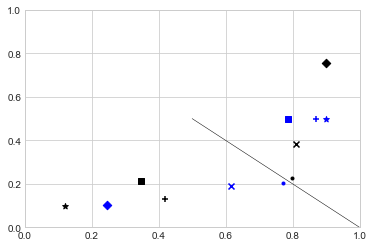

In [6]:
xMatches = np.ones(testNum)
yMatches = np.ones(testNum)

for i in range(testNum):
    xMatches[i] = optimizeMe(yPoints[i] ,funcx)
    yMatches[i] = optimizeMe(xPoints[i] ,funcy)
    
for i in range(6):
    plt.scatter(xPoints[i], yPoints[i], c='k', marker=myMarkers[i])
    plt.scatter(xMatches[i], yMatches[i], c='b', marker=myMarkers[i])
    print("point", myMarkers[i], "has fitness", fitVec[i])
    plt.xlim(0,1)
    plt.ylim(0,1)
plt.plot(x,1-x, 'k', linewidth=0.5)
plt.show()

## 3. Rank and select top points

From these generated points, we now select the numSelect points with the lowest fitness values.

After selection we choose:
point . with fitness 0.036489750109717396
point x with fitness 0.2743346428309747
point s with fitness 0.5228720568305624


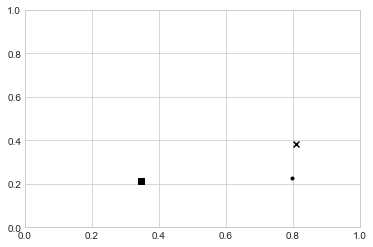

In [7]:
ordered = np.argsort(fitVec)
bestX = [xPoints[ordered[i]] for i in range(3)]
bestY = [yPoints[ordered[i]] for i in range(3)]

print("After selection we choose:")
for i in range(3):
    print("point", myMarkers[ordered[i]], "with fitness", fitVec[ordered[i]])

for i in range(3):
    plt.scatter(xPoints[ordered[i]], yPoints[ordered[i]], c='k', marker=myMarkers[ordered[i]])
    plt.xlim(0,1)
    plt.ylim(0,1)
plt.show()

(0.0, 1.0)

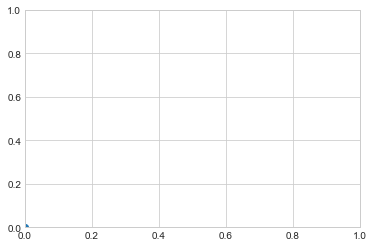

In [9]:
plt.scatter(0,0)
plt.xlim(0,1)
plt.ylim(0,1)

## 4. Linear Regression

y = 0.20544806531292517 * x +  0.14146730641015162


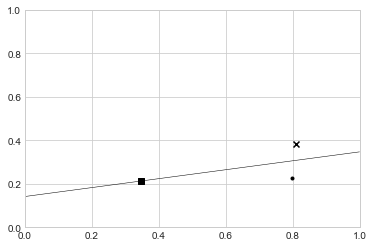

In [10]:
slope, intercept, r_value, p_value, std_err = sp.stats.linregress(bestX, bestY)
x = np.linspace(0, 1, 1000)
for i in range(3):
    plt.scatter(xPoints[ordered[i]], yPoints[ordered[i]], c='k', marker=myMarkers[ordered[i]])

plt.plot(x,intercept + slope*x, 'k', linewidth=0.5)
plt.xlim(0,1)
plt.ylim(0,1)
print("y =", slope, "* x + ", intercept)

saveX = xPoints
saveY = yPoints
saveOrder = ordered
saveBest = bestX

## 5. Generate replacement points using the line

### Generating new X points

To generate replacement points for the ones we removed, we first must select our x points. To determine the range of x values from which we select new points, we use the range of x values from our current selected points and expand it a proportion of the remaining space to the absolute bounds of x.
let minX, maxX represent the min and max x values from bestX (our selected points).
let $x_{floor}$, x_{ceiling} represent the global lower and upper bounds on x (0, 1) in this case
let $\delta = 0.985$, and let i represent the number of generations we have made so far (number of iterations performed)

**We extend the search space from minX and maxX $\delta^i$ of the way to absMinX and absMaxX.**:

choose new $x \in (x_{low}, x_{high})$ such that
$$x_{low} = minX - (minX-x_{floor})\delta^{i}$$
$$x_{high} = maxX + (x_{ceiling} - maxX)\delta^{i}$$


**INTERACTIVE:** Below, try changing the values of "iterationNum", and watch how the search space (space between the red lines) changes. The left line represents $x_{low}$, and the right $x_{high}$. Thus, as our range of x values tends towards the true range of x values in the solution set, our search space too converges onto the solution set. Simultaneously, when the iteration count is still low, we search almost the entire range of possible x values, regardless of where the x points are.
Additionally, one can change the value of $\delta$ to increase or decrease 'step size' (which is inversely proportional to $\delta$). As with other algorithms, larger step size increases rate of convergance, but risks missing the solution set altogether. 

When i = 100 we search between:


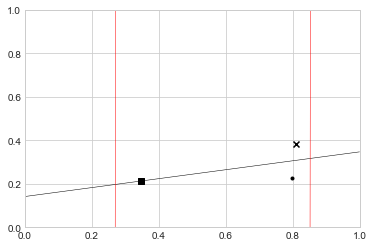

In [14]:
xPoints = saveX
yPoints = saveY
ordered = saveOrder
bestX = saveBest

#CHANGE THESE#
Delta = 0.985
iterationNum = 100
#CHANGE THESE^^^#


xMins = min(bestX) - min(bestX)*(Delta**iterationNum)
xMaxs = max(bestX) + (1 - max(bestX))*(Delta**iterationNum)

for i in range(3):
    plt.scatter(xPoints[ordered[i]], yPoints[ordered[i]], c='k', marker=myMarkers[ordered[i]])

plt.plot(x,intercept + slope*x, 'k', linewidth=0.5)
plt.plot(x,1000*(x-xMins), 'r', linewidth=0.5)
plt.plot(x,1000*(x-xMaxs), 'r', linewidth=0.5)

plt.xlim(0,1)
plt.ylim(0,1)

print("When i =", iterationNum, "we search between:")
plt.show()

Based on our current generation of selected points, the global bounds on x, our current iteration, and the selected delta value, we select the upper and lower bounds for our x search space for the following generation (shown by the red bars). We randomly generate numSelect replacement x points between these bounds for the ones we removed previously. 

Function **nextGenX(Xbest, iterations, Delta)** takes in the x coordinates of the selected points, the iteration number, and the $\delta$ value, and outputs a new vector where the first points are the selected points of the previous generation, and the remaining points are randomly distributed x values within the x search space defined by that generation.

In [16]:
#Global bounds on x
xMinConstr = 0
xMaxConstr = 1
yMinConstr = 0
yMaxConstr = 1

def nextGenX(Xbest, iterations, Delta):
    NewX = np.ones(cols) #initialize a vector of ones

    maxX = max(Xbest)
    minX = min(Xbest)

    #Find lower limit of x search
    bottXDist = minX - xMinConstr
    extXBott = bottXDist*(Delta**iterations)
    minSearchX = minX - extXBott

    #Find upper limit of x search
    topXDist = xMaxConstr - maxX
    extXTop = topXDist*(Delta**iterations)
    maxSearchX = maxX + extXTop

    #Find size of search space to scale 'random' number generator
    xSize = maxSearchX - minSearchX
    
    for i in range(numSelect):
        NewX[i] = Xbest[i]


    for i in range(cols - numSelect):    

        #Select new values of x by taking random numbers from [0,1] and mapping them onto our search space of x
        NewX[numSelect + i] = (random.random() * xSize) + minSearchX
    return NewX

oldX = xPoints
xPoints = nextGenX(bestX, 1, Delta)
print("Our new x vector is", xPoints)

Our new x vector is [0.79794585 0.81054202 0.34688571 0.71175032 0.65174449 0.41180686]


### Generating Y points

To generate replacement y points corresponding to the newly generated x points, we use the line formed in our Linear Regression performed previously, and add in a diminishing force of randomness. We investigate 2 methods to create this randomness. 

#### Y-Range Searching 

The first method of adding randomness to the new y values is accomplished in a very similar way to that achieved by x. For each new $x_{j}$ value, a value $\hat{y}_{j}$ is found using the line created by the previous linear regeression. The initial upper and lower bounds for the $y_{j}$ search are given by $\hat{y}_{j}$, and are then extended $\epsilon^{i}$ of the way to the global upper and lower bounds for y, where i is the current iteration and $\epsilon = 0.985$. $y_{j}$ is then selected randomly between these bounds

**INTERACTIVE:** Below, try changing the values of "iterationNum", and watch how the search space (space between the red lines) changes. Thus, as our range of x values tends towards the true range of x values in the solution set, and our linear regression tends towards the true linear solution, we do not search past this space too much.
Similarly to previously, we can also vary our step sizes with changes applied to $\epsilon$ (y search step size) or $\delta$ (x search step size).

When i = 100 we search between:


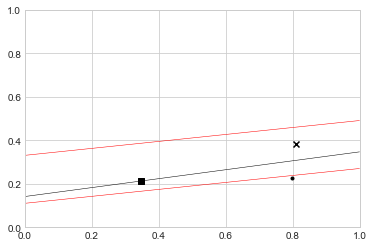

In [21]:
Delta = 0.99
Epsilon = 0.985
iterationNum = 100

xMins = min(bestX) - min(bestX)*(Delta**iterationNum)
xMaxs = max(bestX) + (1 - max(bestX))*(Delta**iterationNum)

yHatXMin = intercept + slope*xMins
yHatXMax = intercept + slope*xMaxs

yMinXMin = yHatXMin + (yMaxConstr-yHatXMin)*(Epsilon**iterationNum)
yMaxXMin = yHatXMin - (yHatXMin-yMinConstr)*(Epsilon**iterationNum)
yMinXMax = yHatXMax + (yMaxConstr-yHatXMax)*(Epsilon**iterationNum)
yMaxXMax = yHatXMax - (yHatXMax-yMinConstr)*(Epsilon**iterationNum)

yTopSlope = (yMaxXMax - yMaxXMin)/(xMaxs-xMins)
yBottSlope = (yMinXMax - yMinXMin)/(xMaxs-xMins)

topIntercept = yMaxXMin - yTopSlope*xMins
bottIntercept = yMinXMin - yBottSlope *xMins

for i in range(3):
    plt.scatter(oldX[ordered[i]], yPoints[ordered[i]], c='k', marker=myMarkers[ordered[i]])

plt.plot(x,intercept + slope*x, 'k', linewidth=0.5)
#plt.plot(x,1000*(x-xMins), 'r', linewidth=0.5)
#plt.plot(x,1000*(x-xMaxs), 'r', linewidth=0.5)

plt.plot(x,yTopSlope*x + topIntercept, 'r', linewidth=0.5)
plt.plot(x,yBottSlope*x + bottIntercept, 'r', linewidth=0.5)

plt.xlim(0,1)
plt.ylim(0,1)

print("When i =", iterationNum, "we search between:")
plt.show()

Function **nextGenYRange(Ybest, iterations, Epsilon)** takes in the y coordinates of the selected points, the iteration number, and the $\epsilon$ value, and returns a new vector where the first points are the selected y values from the previous genration, and the remaining points are randomly distributed values within the y search space defined by that x value, the iteration count, the $\epsilon$ value and the line from that generation

In [22]:
def nextGenYRange(Ybest, iterations, Epsilon):
    NewY = np.ones(cols)
    
    for i in range(numSelect):       
        NewY[i] = Ybest[i]

    #Select new values of y by taking the output from the line function, 
    #and adding/subtracting some sort of error, of size defined by deistance from edge, and diminished by epsilon
    
    for i in range(cols - numSelect):
        y = slope * xPoints[numSelect + i] + intercept
        maxSearchY = y + (yMaxConstr - y) * (Epsilon ** iterations)
        minSearchY = y - y * (Epsilon ** iterations)

        ySize = maxSearchY - minSearchY

        NewY[numSelect + i] = random.random()*ySize+ minSearchY
    
    return NewY

### Error Adding

The second method of adding randomness to $\hat{y}_{j}$ point generated by $x_{j}$ and the linear regression on iteration i is by adding a term to $\hat{y}_{j}$. This term is chosen ranndomly from a set of size (yMaxConstr - yMinConstr) * $\epsilon^{i}$ that is symetrical about 0. So for this problem, we choose random $error \in [-0.5, 0.5] * \epsilon^{i}$, with $\epsilon = 0.985$ so as to slowly diminish the force of randomness. This error is added onto $\hat{y}_{j}$ to create $y_{j}$. With this method, we run the risk of setting $y_{j}$ to a vlaue a outside of our global bounds for y. When this occurs, $y_{j}$ is set to that global bound.

**INTERACTIVE:** Below, try changing the values of "iterationNum", and watch how the search space (space between the red lines) changes. Thus, as our range of x values tends towards the true range of x values in the solution set, and our linear regression tends towards the true linear solution, we search a more local area.

When i = 50 we search between:


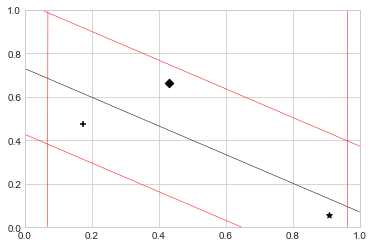

In [12]:
Epsilon = 0.99
iterationNum = 50

xMins = min(bestX) - min(bestX)*(Delta**iterationNum)
xMaxs = max(bestX) + (1 - max(bestX))*(Delta**iterationNum)

ySpan = yMaxConstr - yMinConstr
error = ySpan*(random.random()-0.5)

yHatXMin = intercept + slope*xMins
yHatXMax = intercept + slope*xMaxs

yMinXMin = max(0.00001, yHatXMin - (ySpan*0.5)*(Epsilon**iterationNum))
yMaxXMin = min(0.99999, yHatXMin + (ySpan*0.5)*(Epsilon**iterationNum))
yMinXMax = max(0.00001, yHatXMax - (ySpan*0.5)*(Epsilon**iterationNum))
yMaxXMax = min(0.99999, yHatXMax + (ySpan*0.5)*(Epsilon**iterationNum))


topIntercept = intercept + (ySpan*0.5)*(Epsilon**iterationNum)
bottIntercept = intercept - (ySpan*0.5)*(Epsilon**iterationNum)

for i in range(3):
    plt.scatter(oldX[ordered[i]], yPoints[ordered[i]], c='k', marker=myMarkers[ordered[i]])

plt.plot(x,intercept + slope*x, 'k', linewidth=0.5)
plt.plot(x,1000*(x-xMins), 'r', linewidth=0.5)
plt.plot(x,1000*(x-xMaxs), 'r', linewidth=0.5)

plt.plot(x,slope*x + topIntercept, 'r', linewidth=0.5)
plt.plot(x,slope*x + bottIntercept, 'r', linewidth=0.5)

plt.xlim(0,1)
plt.ylim(0,1)

print("When i =", iterationNum, "we search between:")
plt.show()

function **nextGenYError(Ybest, iterations, Epsilon)** takes in the y coordinates of the selected points, the iteration number, and the $\epsilon$ value, and returns a new vector where the first points are the selected y values from the previous genration, and the remaining points are randomly distributed values within the y search space defined by the linear regretion of that generation, and an error value from a set of size ySpan symetrical about 0, or to the global bounds of y.

In [13]:
def nextGenYError(Ybest, iterations, Epsilon):
    NewY = np.ones(cols)
    ySpan = yMaxConstr - yMinConstr
    for i in range(numSelect):       
        NewY[i] = Ybest[i]

    #Select new values of y by taking the output from the line function, 
    #and adding/subtracting some sort of error, of size defined by deistance from edge, and diminished by epsilon
    
    for i in range(cols - numSelect):
        y = slope * xPoints[numSelect + i] + intercept
        error = (random.random() - 0.5) * ySpan
        

        NewY[numSelect + i] = max(yMinConstr + 0.00001, min(y + error*(Epsilon**iterations), yMaxConstr - 0.000001))

    
    return NewY

## 6. Repeat Until Convergence

### Y-Range Search

We will now repeat this process, but with 20 points in each generation, and selecting the 10 'fitt3est' points each generation. 

STEP ONE:
Run the Following cell once to initialize the first generation:

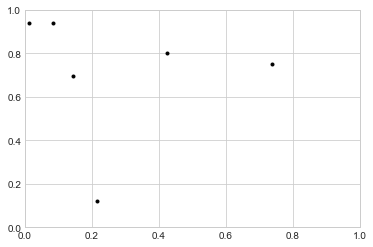

In [52]:
cols = 6
numSelect = 3
inter = 0

xPoints = np.ones(cols)
yPoints = np.ones(cols)
for i in range(cols):
    xPoints[i] = random.random()
    yPoints[i] = random.random()
    plt.scatter(xPoints[i], yPoints[i], c='k', marker='.')
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

**INTERACTIVE**

Now you may run the following cell as many times as you want. Each time you run the cell, it will perform loopsPerClick generations of the Y-Range search algorithm, and plot the top 10 points as, as well as that  generation's search spice.

On iteration = 5 we search between:


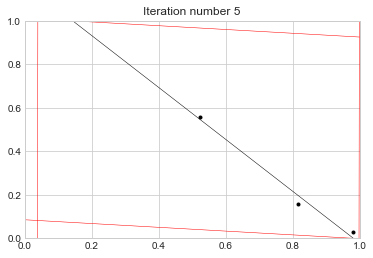

In [60]:
Delta = 0.985
Epsilon = 0.985
loops = 0 #DO NOT CHANGE





########################   CHANGE THIS VALUE IF YOU WANT TO RUN MORE THAN 1 LOOP EACH TIME YOU RUN THE CELL #########
loopsPerClick = 5
#THIS ONE ^^^^^^




while loops < loopsPerClick:
    loops += 1
    inter += 1
    fitVec = findFitness(xPoints, yPoints)
    ordered = np.argsort(fitVec)
    bestX = [xPoints[ordered[i]] for i in range(numSelect)]
    bestY = [yPoints[ordered[i]] for i in range(numSelect)]
    slope, intercept, r_value, p_value, std_err = sp.stats.linregress(bestX, bestY)
    xPoints = nextGenX(bestX, inter + 1, Delta)
    yPoints = nextGenYRange(bestY, inter + 1, Epsilon)

iterationNum = inter

xMins = min(bestX) - min(bestX)*(Delta**iterationNum)
xMaxs = max(bestX) + (1 - max(bestX))*(Delta**iterationNum)

yHatXMin = intercept + slope*xMins
yHatXMax = intercept + slope*xMaxs

yMinXMin = yHatXMin + (yMaxConstr-yHatXMin)*(Epsilon**iterationNum)
yMaxXMin = yHatXMin - (yHatXMin-yMinConstr)*(Epsilon**iterationNum)
yMinXMax = yHatXMax + (yMaxConstr-yHatXMax)*(Epsilon**iterationNum)
yMaxXMax = yHatXMax - (yHatXMax-yMinConstr)*(Epsilon**iterationNum)

yTopSlope = (yMaxXMax - yMaxXMin)/(xMaxs-xMins)
yBottSlope = (yMinXMax - yMinXMin)/(xMaxs-xMins)

topIntercept = yMaxXMin - yTopSlope*xMins
bottIntercept = yMinXMin - yBottSlope *xMins


for i in range(numSelect):
    plt.scatter(bestX[i], bestY[i], c='k', marker='.')

plt.plot(x,intercept + slope*x, 'k', linewidth=0.5)
plt.plot(x,1000*(x-xMins), 'r', linewidth=0.5)
plt.plot(x,1000*(x-xMaxs), 'r', linewidth=0.5)

plt.plot(x,yTopSlope*x + topIntercept, 'r', linewidth=0.5)
plt.plot(x,yBottSlope*x + bottIntercept, 'r', linewidth=0.5)

plt.xlim(0,1)
plt.ylim(0,1)
plt.title("Iteration number 10")

print("On iteration =", iterationNum, "we search between:")
plt.show()

On iteration = 2 we search between:


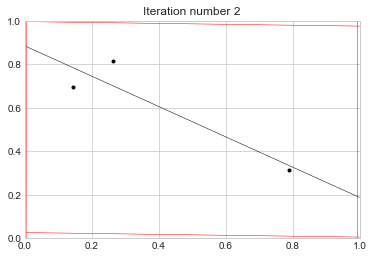

In [57]:
for i in range(numSelect):
    plt.scatter(bestX[i], bestY[i], c='k', marker='.')

plt.plot(x,intercept + slope*x, 'k', linewidth=0.5)
plt.plot(x,1000*(x-xMins), 'r', linewidth=0.5)
plt.plot(x,1000*(x-xMaxs), 'r', linewidth=0.5)

plt.plot(x,yTopSlope*x + topIntercept, 'r', linewidth=0.5)
plt.plot(x,yBottSlope*x + bottIntercept, 'r', linewidth=0.5)

plt.xlim(0,1)
plt.ylim(0,1)
plt.title("Iteration number 2")

print("On iteration =", iterationNum, "we search between:")
plt.show()

In [ ]:
#########
######
######
######
#####

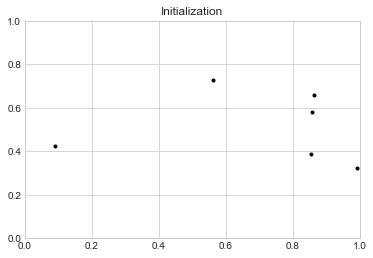

In [67]:
cols = 6
numSelect = 3
inter = 0

xPoints = np.ones(cols)
yPoints = np.ones(cols)
for i in range(cols):
    xPoints[i] = random.random()
    yPoints[i] = random.random()
    plt.scatter(xPoints[i], yPoints[i], c='k', marker='.')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title("Initialization")
plt.savefig('trial 1 0.png')
plt.show()

On iteration = 200 we search between:


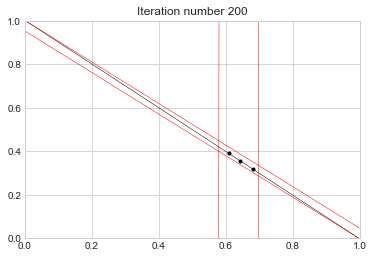

In [103]:
Delta = 0.985
Epsilon = 0.985
loops = 0 #DO NOT CHANGE





########################   CHANGE THIS VALUE IF YOU WANT TO RUN MORE THAN 1 LOOP EACH TIME YOU RUN THE CELL #########
loopsPerClick = 20
#THIS ONE ^^^^^^




while loops < loopsPerClick:
    loops += 1
    inter += 1
    fitVec = findFitness(xPoints, yPoints)
    ordered = np.argsort(fitVec)
    bestX = [xPoints[ordered[i]] for i in range(numSelect)]
    bestY = [yPoints[ordered[i]] for i in range(numSelect)]
    slope, intercept, r_value, p_value, std_err = sp.stats.linregress(bestX, bestY)
    xPoints = nextGenX(bestX, inter + 1, Delta)
    yPoints = nextGenYRange(bestY, inter + 1, Epsilon)

iterationNum = inter

xMins = min(bestX) - min(bestX)*(Delta**iterationNum)
xMaxs = max(bestX) + (1 - max(bestX))*(Delta**iterationNum)

yHatXMin = intercept + slope*xMins
yHatXMax = intercept + slope*xMaxs

yMinXMin = yHatXMin + (yMaxConstr-yHatXMin)*(Epsilon**iterationNum)
yMaxXMin = yHatXMin - (yHatXMin-yMinConstr)*(Epsilon**iterationNum)
yMinXMax = yHatXMax + (yMaxConstr-yHatXMax)*(Epsilon**iterationNum)
yMaxXMax = yHatXMax - (yHatXMax-yMinConstr)*(Epsilon**iterationNum)

yTopSlope = (yMaxXMax - yMaxXMin)/(xMaxs-xMins)
yBottSlope = (yMinXMax - yMinXMin)/(xMaxs-xMins)

topIntercept = yMaxXMin - yTopSlope*xMins
bottIntercept = yMinXMin - yBottSlope *xMins


for i in range(numSelect):
    plt.scatter(bestX[i], bestY[i], c='k', marker='.')

plt.plot(x,intercept + slope*x, 'k', linewidth=0.5)
plt.plot(x,1000*(x-xMins), 'r', linewidth=0.5)
plt.plot(x,1000*(x-xMaxs), 'r', linewidth=0.5)

plt.plot(x,yTopSlope*x + topIntercept, 'r', linewidth=0.5)
plt.plot(x,yBottSlope*x + bottIntercept, 'r', linewidth=0.5)

plt.xlim(0,1)
plt.ylim(0,1)
plt.title("Iteration number 200")

print("On iteration =", iterationNum, "we search between:")
plt.savefig('trial 1 200.png')
plt.show()

On iteration = 7 we search between:


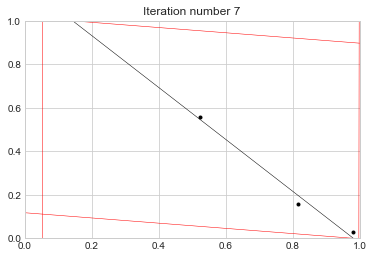

In [65]:
for i in range(numSelect):
    plt.scatter(bestX[i], bestY[i], c='k', marker='.')

plt.plot(x,intercept + slope*x, 'k', linewidth=0.5)
plt.plot(x,1000*(x-xMins), 'r', linewidth=0.5)
plt.plot(x,1000*(x-xMaxs), 'r', linewidth=0.5)

plt.plot(x,yTopSlope*x + topIntercept, 'r', linewidth=0.5)
plt.plot(x,yBottSlope*x + bottIntercept, 'r', linewidth=0.5)

plt.xlim(0,1)
plt.ylim(0,1)
plt.title("Iteration number 7")

print("On iteration =", iterationNum, "we search between:")
plt.savefig('trial 1 7.png')
plt.show()

### Error Adding

We will now repeat this process, but with 20 points in each generation, and selecting the 10 'fitt3est' points each generation. 

STEP ONE:
Run the Following cell once to initialize the first generation:

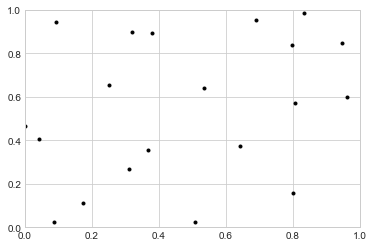

In [16]:
cols = 20
numSelect = 10
inter = 0

xPoints = np.ones(cols)
yPoints = np.ones(cols)
for i in range(cols):
    xPoints[i] = random.random()
    yPoints[i] = random.random()
    plt.scatter(xPoints[i], yPoints[i], c='k', marker='.')
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

**INTERACTIVE**

Now you may run the following cell as many times as you want. Each time you run the cell, it will perform loopsPerClick generations of the Error Adding algorithm, and plot the top 10 points as, as well as that  generation's search spice.

When i = 5 we search between:


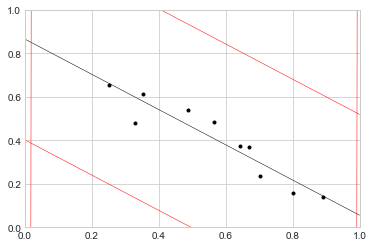

In [17]:
Delta = 0.985
Epsilon = 0.985

loops = 0





########################   CHANGE THIS VALUE IF YOU WANT TO RUN MORE THAN 1 LOOP EACH TIME YOU RUN THE CELL #########
loopsPerClick = 5
#THIS ONE ^^^^^^




while loops < loopsPerClick:
    loops += 1
    inter += 1
    fitVec = findFitness(xPoints, yPoints)
    ordered = np.argsort(fitVec)
    bestX = [xPoints[ordered[i]] for i in range(numSelect)]
    bestY = [yPoints[ordered[i]] for i in range(numSelect)]
    slope, intercept, r_value, p_value, std_err = sp.stats.linregress(bestX, bestY)
    xPoints = nextGenX(bestX, inter + 1, Delta)
    yPoints = nextGenYError(bestY, inter + 1, Epsilon)

iterationNum = inter

xMins = min(bestX) - min(bestX)*(Delta**iterationNum)
xMaxs = max(bestX) + (1 - max(bestX))*(Delta**iterationNum)

ySpan = yMaxConstr - yMinConstr
error = ySpan*(random.random()-0.5)

yHatXMin = intercept + slope*xMins
yHatXMax = intercept + slope*xMaxs

yMinXMin = max(0.00001, yHatXMin - (ySpan*0.5)*(Epsilon**iterationNum))
yMaxXMin = min(0.99999, yHatXMin + (ySpan*0.5)*(Epsilon**iterationNum))
yMinXMax = max(0.00001, yHatXMax - (ySpan*0.5)*(Epsilon**iterationNum))
yMaxXMax = min(0.99999, yHatXMax + (ySpan*0.5)*(Epsilon**iterationNum))



topIntercept = intercept + (ySpan*0.5)*(Epsilon**iterationNum)
bottIntercept = intercept - (ySpan*0.5)*(Epsilon**iterationNum)

for i in range(numSelect):
    plt.scatter(bestX[i], bestY[i], c='k', marker='.')

plt.plot(x,intercept + slope*x, 'k', linewidth=0.5)
plt.plot(x,1000*(x-xMins), 'r', linewidth=0.5)
plt.plot(x,1000*(x-xMaxs), 'r', linewidth=0.5)

plt.plot(x,slope*x + topIntercept, 'r', linewidth=0.5)
plt.plot(x,slope*x + bottIntercept, 'r', linewidth=0.5)

plt.xlim(0,1)
plt.ylim(0,1)

print("When i =", iterationNum, "we search between:")
plt.show()